## Import packages and data

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [32]:
h5ad_file = "/home/shpc_100839/cd8tcell.harmony.h5ad"

In [33]:
adata = sc.read_h5ad(h5ad_file)
adata

AnnData object with n_obs × n_vars = 23571 × 41821
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'cell.id', 'singler.label', 'singler.celltype.compartment', 'paper.celltype.compartment', 'paper.celltype.major', 'paper.celltype.minor', 'paper.celltype.subset', 'primary.subtype', 'site', 'study', 'celltype.compartment', 'sample', 'celltypist.celltype.major', 'celltypist.celltype.minor', 'celltypist.celltype.subset', 'scibet.celltype.subset', 'scibet.celltype.minor', 'scibet.celltype.marker', 'RNA_snn_res.0.8', 'seurat_clusters'
    var: 'features'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

## Pre-process the data


In [34]:
# filter, normalize total counts and log-transform
sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# hvg annotation
sc.pp.highly_variable_genes(adata)
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")

# use scVelo's `moments` function for imputation - note that hack we're using here:
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X

#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.scale(adata, max_value=10)
#sc.tl.pca(adata, svd_solver='arpack')
#sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
#sc.tl.umap(adata)

Normalized count data: X.
This detected 1698 highly variable genes. 


In [35]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:01:54) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Initialize the CytoTRACE kernel


In [36]:
from cellrank.kernels import CytoTRACEKernel

CytoTRACEKernel(adata).compute_cytotrace()

Computing CytoTRACE score with `19519` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:09)
Computing CytoTRACE score with `19519` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:07)


In [37]:
adata

AnnData object with n_obs × n_vars = 23571 × 19519
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'cell.id', 'singler.label', 'singler.celltype.compartment', 'paper.celltype.compartment', 'paper.celltype.major', 'paper.celltype.minor', 'paper.celltype.subset', 'primary.subtype', 'site', 'study', 'celltype.compartment', 'sample', 'celltypist.celltype.major', 'celltypist.celltype.minor', 'celltypist.celltype.subset', 'scibet.celltype.subset', 'scibet.celltype.minor', 'scibet.celltype.marker', 'RNA_snn_res.0.8', 'seurat_clusters', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'features', 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'log1p', 'hvg', 'neighbors', 'ct_params'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [38]:
adata.obs["ct_pseudotime"] = 1-adata.obs["ct_pseudotime"]

/home/shpc_100839/miniconda3/envs/trajectory/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


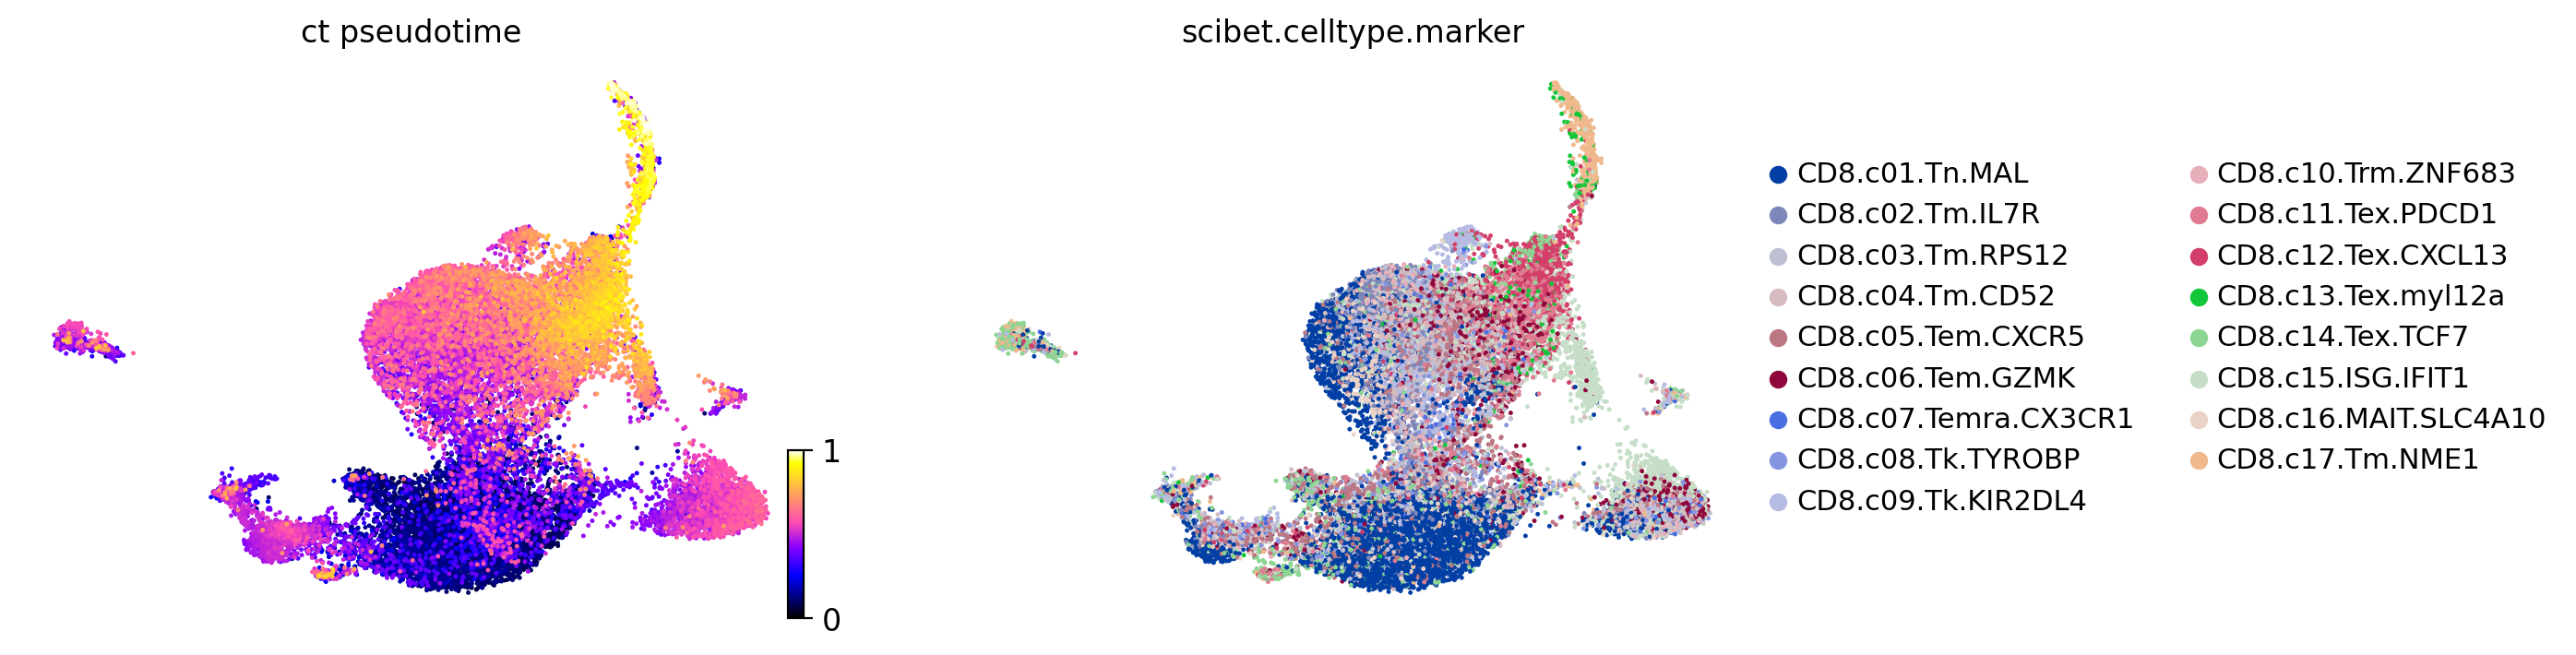

In [39]:
scv.pl.scatter(
    adata,
    c=["ct_pseudotime", "scibet.celltype.marker"],
    basis="X_umap",
    legend_loc="right",
    color_map="gnuplot2",
)

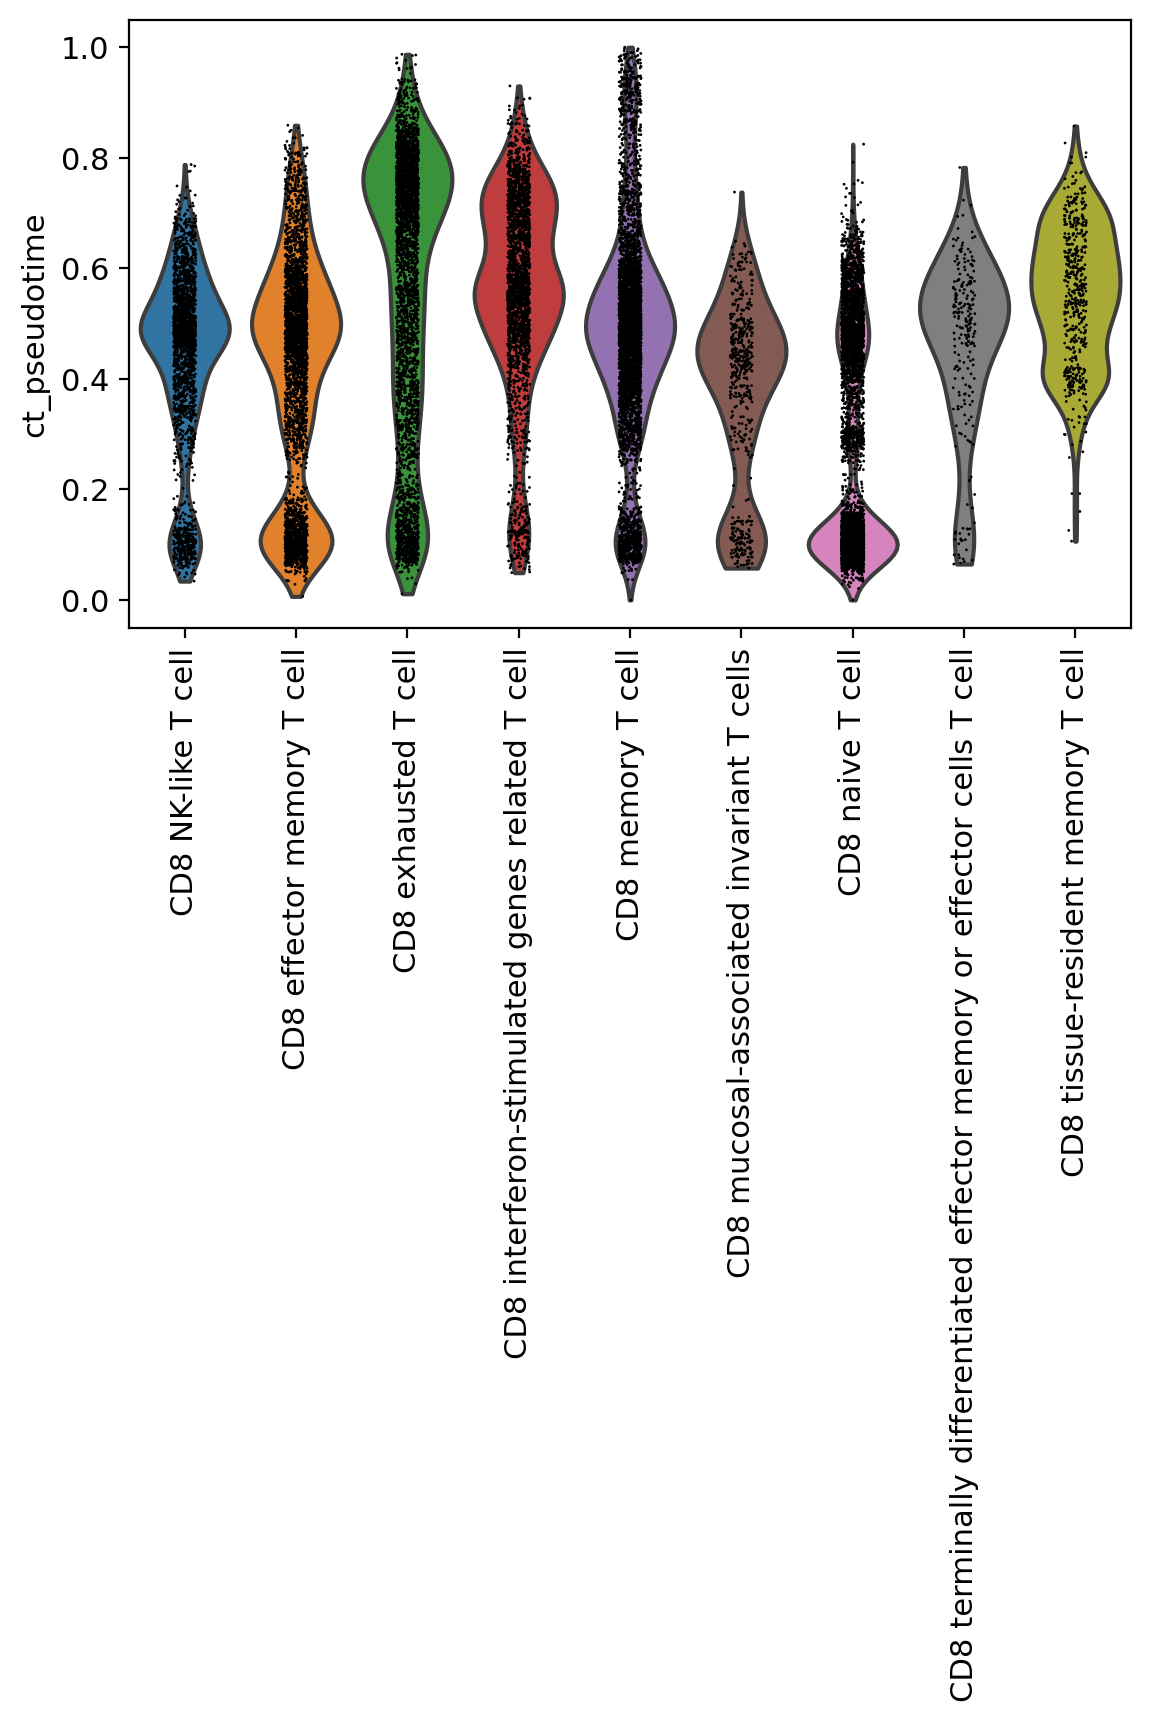

In [40]:
sc.pl.violin(adata, keys=["ct_pseudotime"], groupby="scibet.celltype.subset", rotation=90)

## Compute & visualize a transition matrix


In [41]:
ctk = CytoTRACEKernel(adata).compute_transition_matrix(threshold_scheme="soft", nu=0.5)

Computing CytoTRACE score with `19519` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:03)
Computing transition matrix based on `ct_pseudotime`


100%|██████████| 23571/23571 [00:20<00:00, 1144.60cell/s]


    Finish (0:00:43)


In [42]:
adata.obs["ct_pseudotime"] = 1-adata.obs["ct_pseudotime"]

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:24)


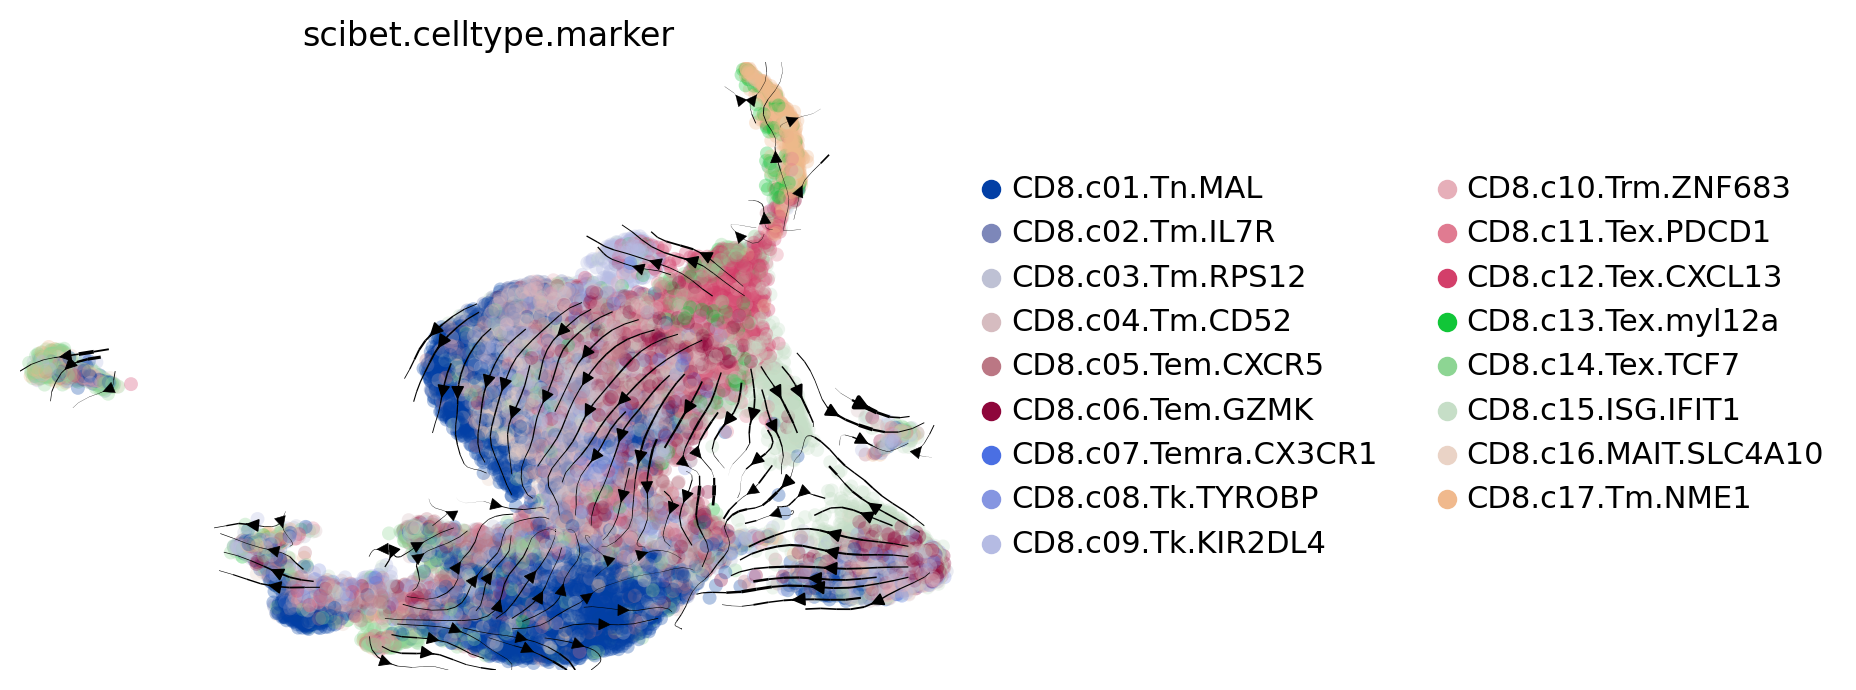

In [44]:
ctk.compute_projection()
scv.pl.velocity_embedding_stream(
    adata, color="scibet.celltype.marker", vkey="T_fwd", legend_loc="right"
)

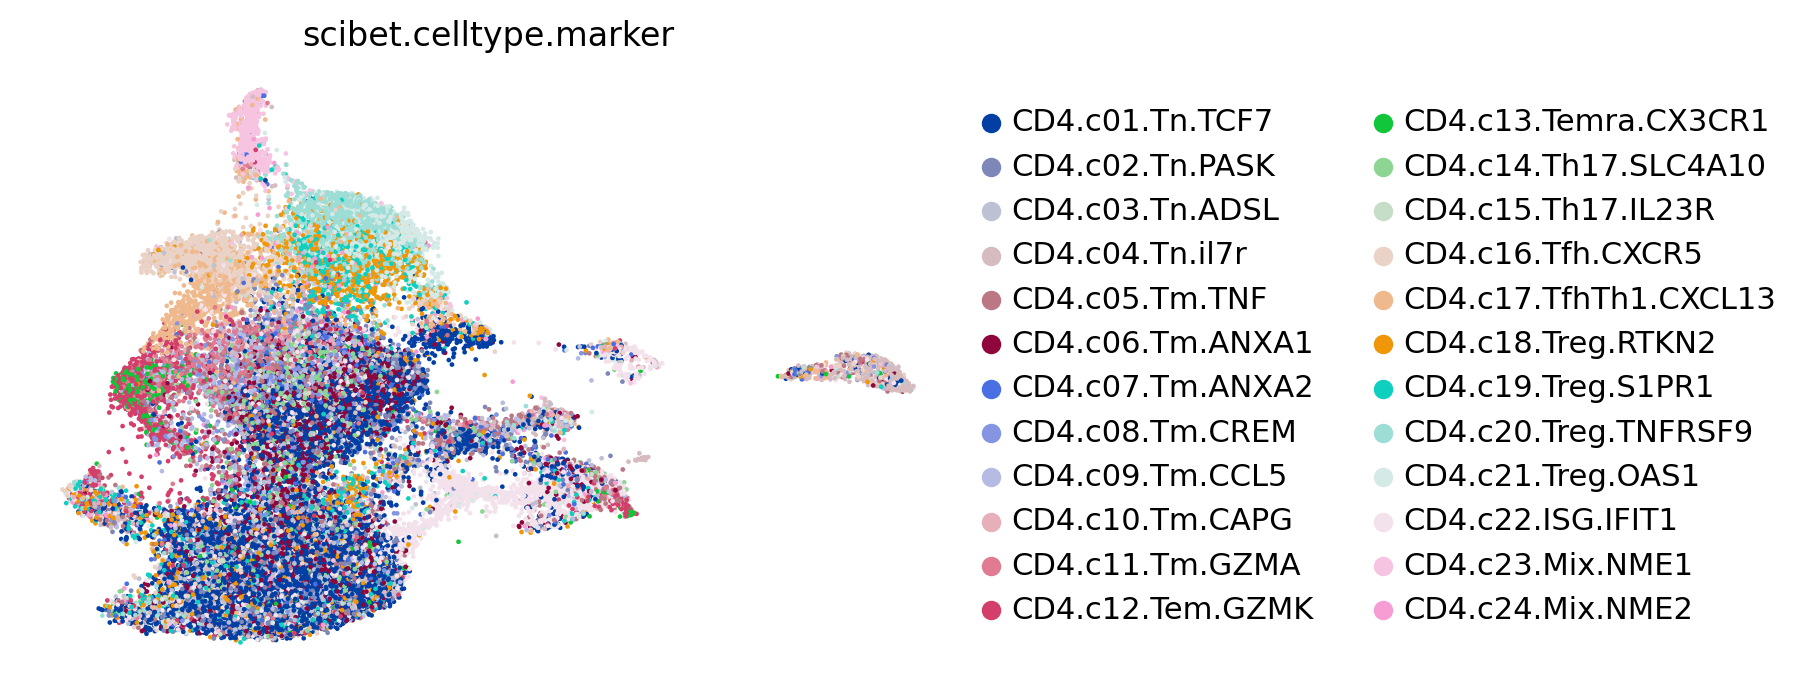

In [ ]:
scv.pl.scatter(
    adata, basis="umap", c="scibet.celltype.marker", 
    legend_loc="right"
)

Simulating `15` random walks of maximum length `10070`


100%|██████████| 15/15 [02:18<00:00,  9.21s/sim]


    Finish (0:02:18)
Plotting random walks


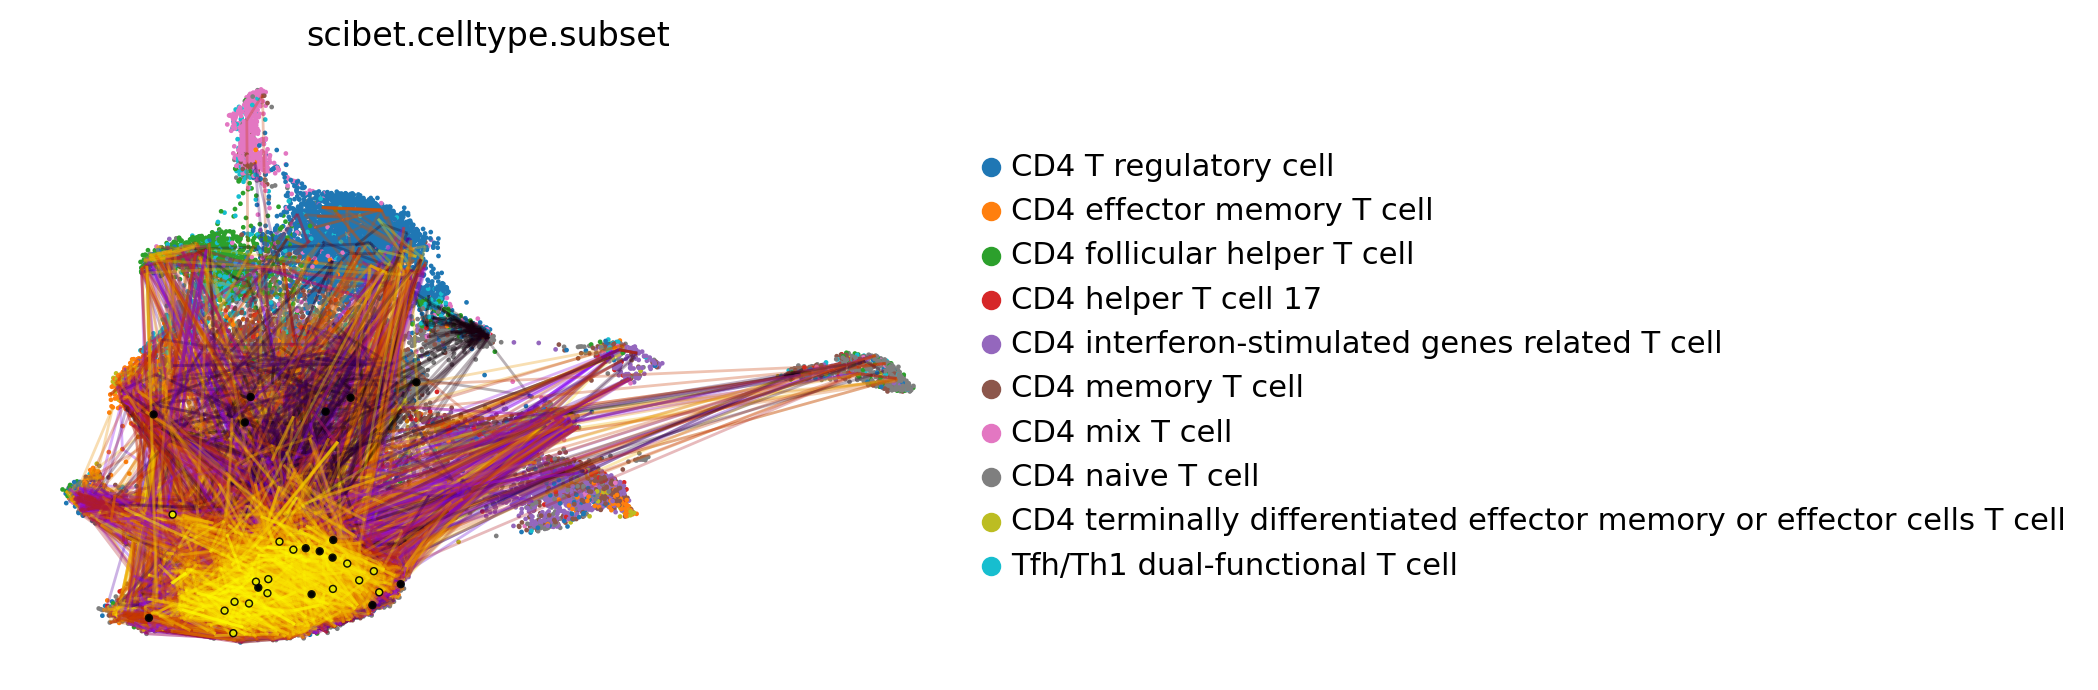

In [20]:
ctk.plot_random_walks(
    n_sims=15,
    start_ixs={"scibet.celltype.marker": "CD4.c01.Tn.TCF7"},
    #basis="force_directed",
    color="scibet.celltype.subset",
    legend_loc="right",
    seed=1,
)

## Compute macrostates


In [29]:
from cellrank.tl.estimators import GPCCA

g_fwd = GPCCA(ctk)
print(g_fwd)

GPCCA[n=33014, kernel=<CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>]


Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999578e-01 4.5690618616749394e-04 -9.5776938050809039e-05 5.2776930854430085e-03 -5.1283631173739642e-03 7.1502552951350931e-04 2.2939352327133958e-02 -1.7374554159755858e-02 -1.9335259988256300e-02 7.8425430219431717e-03 1.2992873211152861e-02 -3.3895675660508486e-03 3.0513328452580215e-03 3.9868941234559264e-03 1.8036402316154807e-03 -7.1214905129841043e-03 -3.6229034028041011e-03 -1.4894126814372348e-02 5.8999716272939038e-03 -5.6224872656548477e-03 
0.0000000000000000e+00 9.9942705993405334e-01 -2.6994133647452442e-05 -5.7275669543108889e-03 4.1173501487998047e-05 -1.5269005735889143e-03 1.3673167779348475e-02 -5.1993593752422060e-03 -9.6985336052190750e-03 7.0583389306036288e-03 -1.0784351889242209e-02 -1.3134701198185737e-02 -2.2770703948303715e-03 4.6449791550399215e-03 1.4726098582712671e-03 7.7833201590091329e-03 9.3286811322067372e-04 -3.6730368883886567e-03 4.9774585432155799e-03 3.3127577

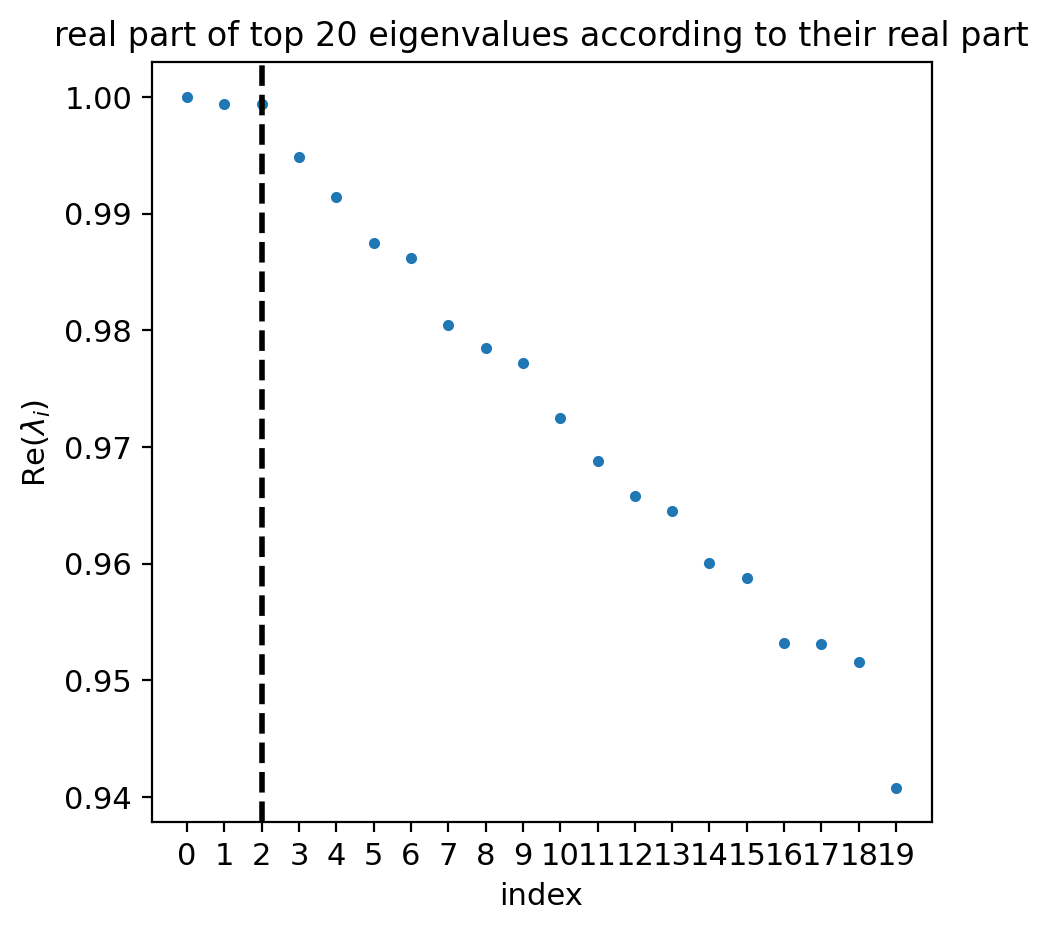

In [30]:
g_fwd.compute_schur(n_components=20)
g_fwd.plot_spectrum(real_only=True)

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:02)


/home/shpc_100839/miniconda3/envs/trajectory/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


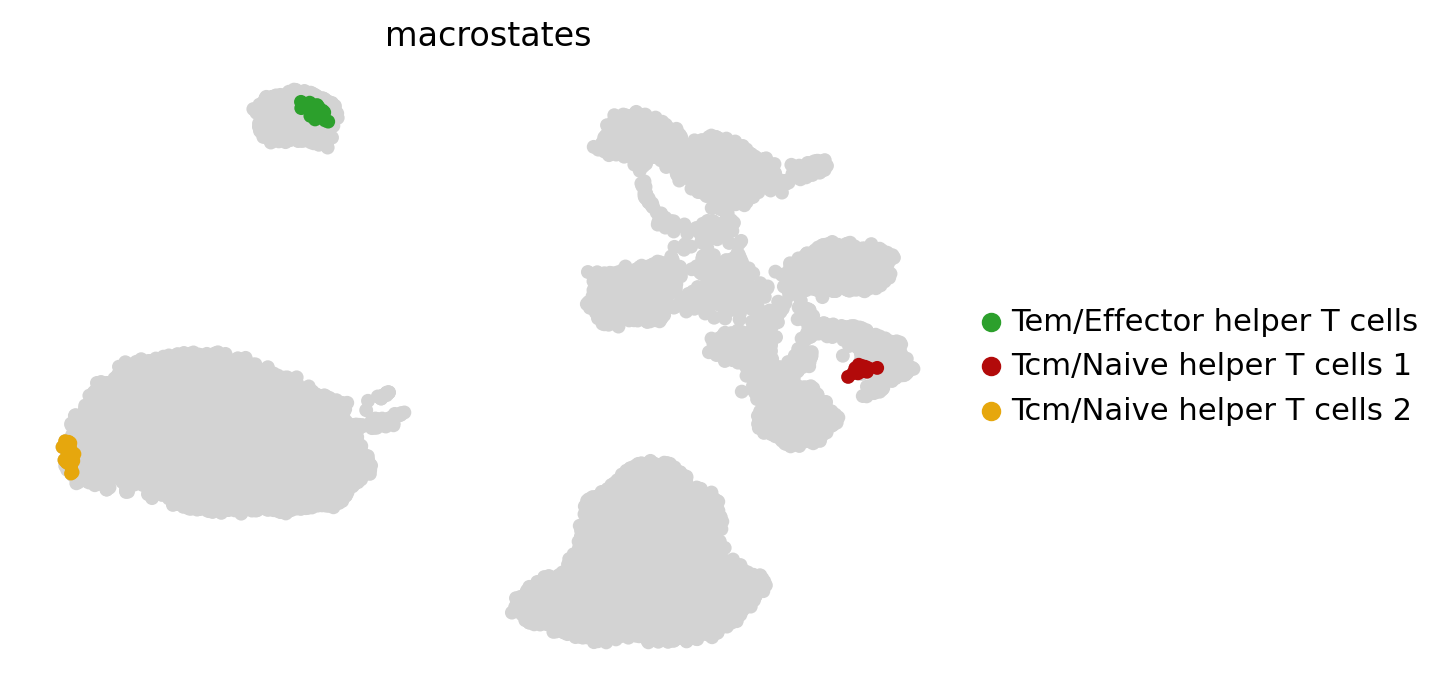

In [33]:
g_fwd.compute_macrostates(n_states=3, cluster_key="celltype.subset")
g_fwd.plot_macrostates(
    discrete=True, legend_loc="right", size=100 #,basis="umap"
)

/home/shpc_100839/miniconda3/envs/trajectory/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/shpc_100839/miniconda3/envs/trajectory/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


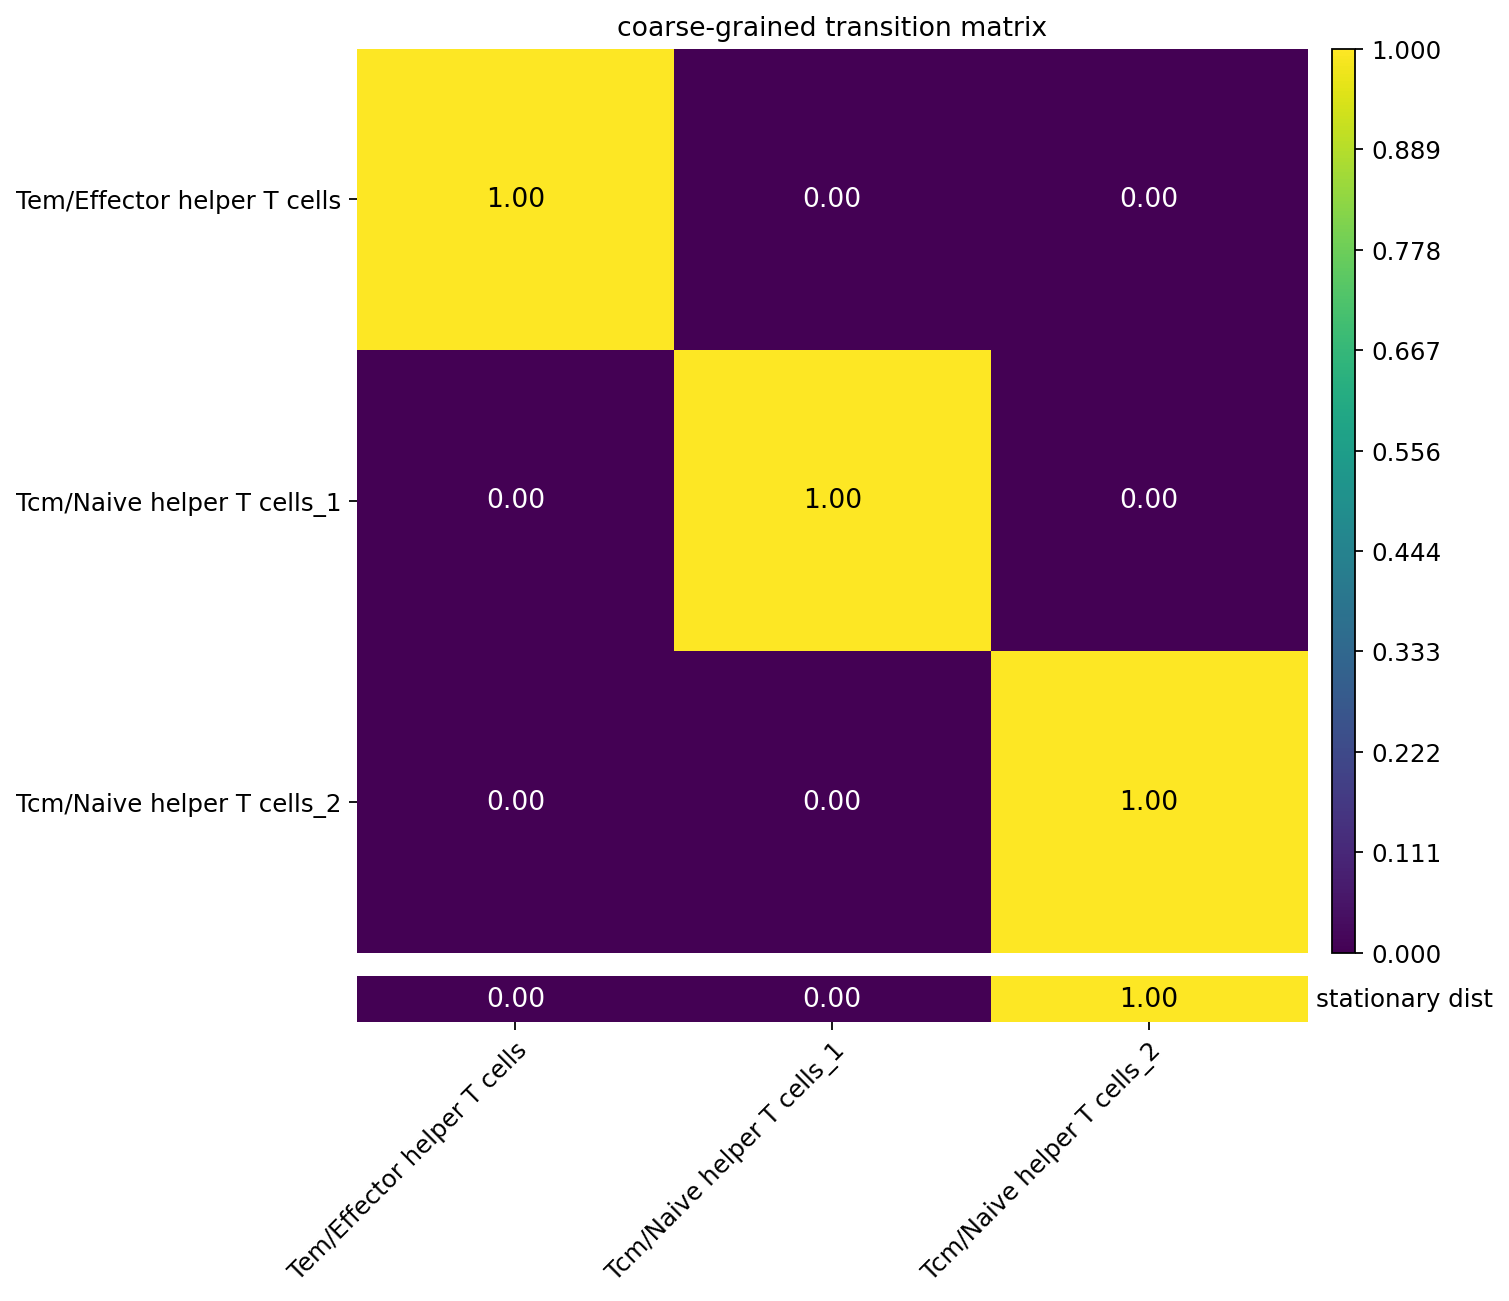

In [34]:
g_fwd.plot_coarse_T()

In [ ]:
g_fwd.compute_macrostates(n_states=3, cluster_key="celltype.subset")
g_fwd.set_terminal_states_from_macrostates(names=["Prechordal Plate", "Notochord"])

## Compute fate probabilities


In [35]:
g_fwd.compute_absorption_probabilities()
g_fwd.plot_absorption_probabilities(same_plot=False, size=50, basis="force_directed")

RuntimeError: Compute terminal states first as `.compute_terminal_states()`.

In [ ]:
scv.pl.scatter(adata, basis="force_directed", c="lineages")

## Directed PAGA


In [ ]:
scv.tl.recover_latent_time(
    adata, root_key="initial_states_probs", end_key="terminal_states_probs"
)

In [ ]:
scv.tl.paga(
    adata,
    groups="clusters",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="velocity_pseudotime",
)

In [ ]:
cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="clusters",
    basis="umap",
    legend_kwargs={"loc": "top right out"},
    legend_loc="top left out",
    node_size_scale=5,
    edge_width_scale=1,
    max_edge_width=4,
    title="directed PAGA",
)

## Compute lineage drivers


In [ ]:
cr.tl.lineage_drivers(adata)

In [ ]:
cr.pl.lineage_drivers(adata, lineage="Alpha", n_genes=5)


## Gene expression trends

In [ ]:
# compue DPT, starting from CellRank defined root cell
root_idx = np.where(adata.obs["initial_states"] == "Ngn3 low EP")[0][0]
adata.uns["iroot"] = root_idx
sc.tl.dpt(adata)

scv.pl.scatter(
    adata,
    color=["clusters", root_idx, "latent_time", "dpt_pseudotime"],
    fontsize=16,
    cmap="viridis",
    perc=[2, 98],
    colorbar=True,
    rescale_color=[0, 1],
    title=["clusters", "root cell", "latent time", "dpt pseudotime"],
)

In [ ]:
model = cr.ul.models.GAM(adata)
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="X",
    genes=["Pak3", "Neurog3", "Ghrl"],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

In [ ]:
cr.pl.heatmap(
    adata,
    model,
    genes=adata.varm['terminal_lineage_drivers']["Alpha_corr"].sort_values(ascending=False).index[:100],
    show_absorption_probabilities=True,
    lineages="Alpha",
    n_jobs=1,
    backend="loky",
)